# Analysis of tutoring center sign-in data

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Read in the data kept in the ..\Dropbox\sign_in_exports folder
Right now we're just manually grabbing one csv file.  But we could script this to grab the most recent file in the folder.

In [2]:
df = pd.read_csv(r'D:\Users\jconning\Dropbox\sign_in_exports\sign_in_export_2015-10-28.csv')

# Summary statistics
The pandas groupby method generates a dictionary. For example if we group by course as below it will create a dictionary where the keys are each course 100, 200, 201 etc and for each key the row numbers where that course appears.

Once we have that dictionary we can use counts and other methods.

In [3]:
byDay = df.groupby('Date')
df_Day = byDay.size()
df_Day

Date
2015-09-05     1
2015-09-16     3
2015-09-17     7
2015-09-18     3
2015-09-21     9
2015-09-24    14
2015-09-25     7
2015-09-28    20
2015-09-29     9
2015-09-30    11
2015-10-01    12
2015-10-02    11
2015-10-03     3
2015-10-05    26
2015-10-06    16
2015-10-07    11
2015-10-08    15
2015-10-09     6
2015-10-10     2
2015-10-13    10
2015-10-14    10
2015-10-15     6
2015-10-16     1
2015-10-19    17
2015-10-20     9
2015-10-21    21
dtype: int64

## Visits by date
The plot below is not quite right because we haven't told pandas to use a datetime index.

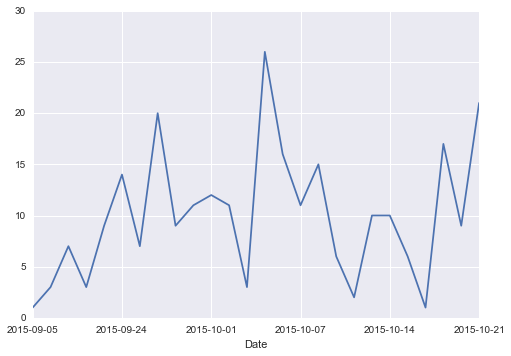

In [4]:
df_Day.plot()

It would be nice to use the python (or pandas) datetime library methods to graph by day of the week

## By course and instructor

In [5]:
byCourse = df.groupby(['Catalog Num'])
df_Course = byCourse.size()
df_Course

Catalog Num
10000    77
20000    31
20100     4
21000     1
22100    17
26000     3
30000    49
30100     5
30500     1
32100     9
33000     2
34000    21
34500    11
35500    15
36500    10
36600     1
38000     1
39556     1
dtype: int64

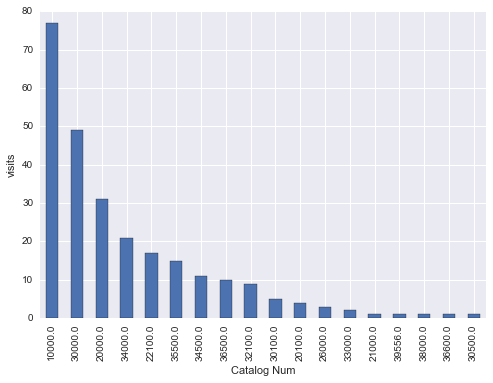

In [6]:
Courseplot = df_Course.sort_values(ascending=False).plot(kind='bar')
Courseplot.set_ylabel("visits")

In [7]:
byCourseProf = df.groupby(['Catalog Num','Instructor'])
df_CourseProf = byCourseProf.size().sort_values(ascending=False)
df_CourseProf

Catalog Num  Instructor  
10000        George          55
30000        Wright          49
34000        Conning         21
20000        Basu            20
35500        George          15
22100        Nugent          13
10000        Filer           13
34500        Sevak           11
36500        Ma               8
32100        Gharehogozli     8
20000        Nugent           6
10000        Chernick         5
30100        Silverstein      4
20100        Abreu            4
20000        Deb              4
10000        Goodspeed        4
26000        Nyman            3
22100        Demir            3
33000        Gurevich         2
36500        Lu               2
30100        Agbeyegbe        1
38000        Altieri          1
30500        Baker            1
22100        Leboeuf          1
20000        Sevak            1
32100        Leboeuf          1
36600        Carias           1
39556        Chaterjee        1
dtype: int64

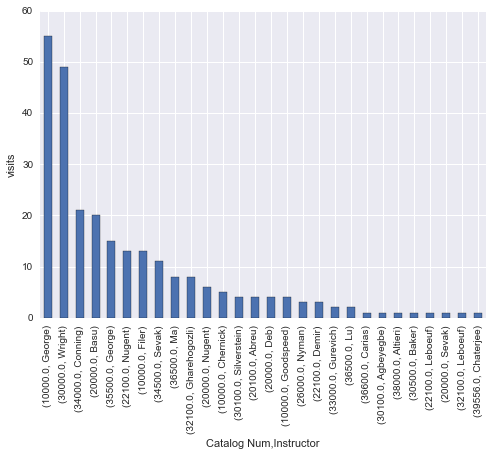

In [8]:
CourseProfplot = df_CourseProf.sort_values(ascending=False).plot(kind='bar')
CourseProfplot.set_ylabel("visits")

##  Some things we could do
   - Calendar analysis
      - What days/times get most or least
      - Calendar heatmap
   -  Agree on condensed summary report to send profs
       - 'this week'
       - 'semester to date'
   - more detailed report to profs
       - list of students
   - 